# Attempt at running over Timepoints

In [48]:
import numpy as np
import seaborn as sns
from scipy.linalg import eig
import matplotlib.pyplot as plt 

from modules.LDS import Kalman_EM, calc_ALS
from modules.WF_sim import *

from scipy.optimize import minimize
from scipy.optimize import nnls
from pathlib import Path

from tqdm import tqdm


Total counts shape:  (10, 50)
A is not provide! A_demo is used.
(10, 50, 50)


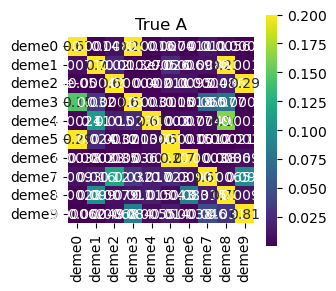

In [61]:
ND = 10 # the number of demes 
T=50 # the number of timepoints
Csn =[0.0]*ND # strength of measurement noise overdispersion
Npop = [100000]*ND # effective population size
if ND == 3:
    totcounts=np.array([[2000,3000,1500]]*T).T # number of sequences sampled from each region
elif ND > 3:
    totcounts = np.random.randint(1000, 3000, size=(ND, T))  # random counts for each deme at each timepoint
print("Total counts shape: ", totcounts.shape)

Ntraj = 50 # number of trajectories to simulate
A,counts,B=WF_sim(Npop, totcounts, Csn, ND, T, A=None, Ntraj=Ntraj)
print(counts.shape)
demes=['deme'+str(i) for i in range(ND)]

freqs = counts / (totcounts[:,None,:]) #calculating frequencies over all trajectories

plt.figure(figsize=[3,3])
sns.heatmap(A,cmap='viridis',vmax=0.2,annot=True,xticklabels=demes, yticklabels=demes,square=True)
plt.title('True A')
plt.show()

# find the lowest left eigenvector of A
eigvals, eigvecs = eig(A, left=True, right=False)
# normalize the eigenvectors
eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_true = -eigvecs[:, np.argmax(eigvals.real)]
ordering = np.flip(np.argsort(eigvals.real))
eigvals = eigvals[ordering]
eigvecs = eigvecs[:,ordering]

pi_true=eigvec_true/np.sum(eigvec_true)

50
Using qp solver:   [0.13132329 0.09431087 0.05646503 0.16352287 0.0411845  0.06967681
 0.08043343 0.06712389 0.17403232 0.12192701]
Using analytic:    [0.13734314 0.09630138 0.0508408  0.17039713 0.02565818 0.07275277
 0.0808942  0.07036123 0.17502549 0.12042567]
Exact pi vector:   [0.1496073 -0.j 0.09609158-0.j 0.04340595-0.j 0.17872518-0.j
 0.01912392-0.j 0.07206774-0.j 0.07759506-0.j 0.06794467-0.j
 0.18070778-0.j 0.11473082-0.j]
L[$\pi_{qp}$]=2.705916761049974e-08
L[$\pi_{guess}$]=2.619465123390451e-08
L[$\pi_{true}$]=2.695225832973539e-08


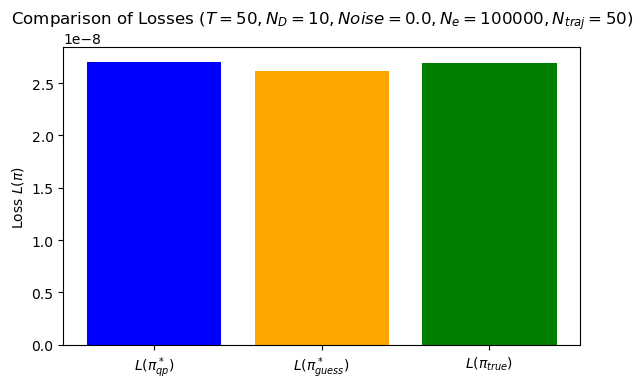

In [62]:
print (Ntraj)

#manufacturing the D matrix, and solving for initial pi values
def D_mat(freqs, τ):
    ND, Ntraj, T = freqs.shape
    df_rows = []
    for mu in range(Ntraj):
        if τ == -1:
            for t in range(T):
                for tau in range(t+1,T):
                    delta_f=freqs[:,mu,tau]-freqs[:,mu,t]
                    delta_f *= (1-0.0**(np.abs(tau-t))) #used to ensure only taking into account tau /= t
                    df_rows.append(delta_f)
        else:
            for t in range(T-τ):
                delta_f=freqs[:,mu,t+τ]-freqs[:,mu,t]
                df_rows.append(delta_f)
    D=np.stack(df_rows, axis=0)/np.sqrt(len(df_rows))
    return D
    
def base_L(pi, freqs, lamb, τ):
    ND=freqs.shape[0]
    pi=np.real(pi) #ensure real values
    pi = pi/np.sum(pi) #ensure normalisation
    D =D_mat(freqs, τ)
    D_pi= D@ pi
    mat=D_pi.T @ D_pi
    L= (mat + lamb*(1-np.sum(pi)))

    return L
def grad_base_L(pi, freqs, lamb, τ):
    D=D_mat(freqs, τ)
    grad_L=2*(D.T @ D) @ pi - lamb
    return grad_L

def pi_finder_simple(freqs, τ):
    ND, Ntraj, T = freqs.shape
    D=D_mat(freqs, τ)
    one=np.ones(ND)
    lamb_inv=(one.T @ np.linalg.inv(D.T @ D) @ one)/2
    lamb=1/lamb_inv
    pi=lamb/2 * np.linalg.inv(D.T @ D) @ one
    return pi

from cvxopt import matrix, solvers

def pi_qp(D):
  # Quadratic programming to solve for pi*

  ND = D.shape[1]
  P = matrix(2 * (D.T @ D))  # Quadratic term (must be symmetric)
  q = matrix(np.zeros(ND))   # Linear term

  # Constrain pi >= 0
  G = matrix(-np.eye(ND))    # -pi <= 0
  h = matrix(np.zeros(ND))
  # Constrain sum(pi) = 1
  A = matrix(np.ones((1, ND)))
  b = matrix(np.array([1.0]))

  sol = solvers.qp(P, q, G, h, A, b) # minimize (1/2)x'Px + q'x subject to Gx <= h, Ax = b
  pi_star = np.array(sol['x']).flatten()
  return pi_star

def pi_finder_qp(freqs, τ):
    D = D_mat(freqs, τ)
    
    pi_star = pi_qp(D)
    return pi_star

pi_star_qp = pi_finder_qp(freqs, τ=1)
pi_star = pi_finder_simple(freqs, τ=1)

L_qp=base_L(pi_star_qp, freqs, 1, 1)
L_guess = base_L(pi_star, freqs, 1,1)
L_true = base_L(pi_true, freqs, 1, 1)


print("Using qp solver:  ", pi_star_qp)
print("Using analytic:   ", pi_star)
print("Exact pi vector:  ", pi_true)

print(rf'L[$\pi_{{qp}}$]={L_qp}')
print(rf'L[$\pi_{{guess}}$]={L_guess}')
print(rf'L[$\pi_{{true}}$]={L_true}')

labels = [r'$L(\pi^*_{qp})$', r'$L(\pi^*_{guess})$', r'$L(\pi_{true})$']
values = [L_qp, L_guess, L_true]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.ylabel(r'Loss $L(\pi)$')
plt.title(rf'Comparison of Losses ($T={T}, N_{{D}}={ND}, Noise = {Csn[0]}, N_e = {Npop[0]}, N_{{traj}} = {Ntraj}$)')
plt.tight_layout()
plt.show()

In [58]:
# run comparison systematically over timepoints

np.random.seed(42)

pi_stars_all_times = []
loss_all_times = []


T_min=5
T_max=50
Ts = np.arange(T_min, T_max+1, 2)
Ts = np.repeat(Ts, 5)  # repeat each ND value 10 times for multiple runs
for T in tqdm(Ts):
    Csn = [0.0] * ND  # strength of measurement noise overdispersion
    Npop = [10000] * ND  # effective population size
    ND = 10
    time_lags =[1,T-1]

    if ND == 3:
        totcounts = np.array([[2000, 3000, 1500]] * T).T  # number of sequences sampled from each region
    elif ND != 3:
        totcounts = np.random.randint(1000, 3000, size=(ND, T))  # random counts for each deme at each timepoint

    Ntraj = 50  # number of trajectories to simulate
    A, counts, B = WF_sim(Npop, totcounts, Csn, ND, T, A=None, Ntraj=Ntraj)
    freqs = counts / (totcounts[:, None, :])  # calculating frequencies over all trajectories

    # run Kalman EM
    A_LS = calc_ALS(counts+1, counts_deme=totcounts)
    
    eigvals_LS, eigvecs_LS = eig(A_LS, left=True, right=False)
    eigvec_LS = eigvecs_LS[:, np.argmax(eigvals_LS.real)]
    pi_LS = eigvec_LS / np.sum(eigvec_LS)

    pi_stars = []
    pi_simples = []
    losses_stars = []
    losses_simples =[]
    losses_true =[]
    losses_LS = []

    lamb=1

    eigvals, eigvecs = eig(A, left=True, right=False)
    # normalize the eigenvectors
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
    eigvec_true = -eigvecs[:, np.argmax(eigvals.real)]
    pi_true = eigvec_true / np.sum(eigvec_true)

    for τ in time_lags:
        pi_star = pi_finder_qp(freqs, τ=τ)
        pi_simple = pi_finder_simple(freqs, τ=τ)
        
        loss_simple = base_L(pi_simple, freqs, lamb, τ=τ) #also update loss function over time steps and demes
        loss_star = base_L(pi_star, freqs, lamb, τ=τ)
        
        pi_stars.append(pi_star)
        pi_simples.append(pi_simple)
        
        losses_stars.append(loss_star) 
        losses_simples.append(loss_simple)

        loss_true = base_L(pi_true, freqs, lamb, τ=τ)
        loss_LS = base_L(pi_LS, freqs, lamb, τ=τ)

        losses_true.append(loss_true)
        losses_LS.append(loss_LS)

    pi_stars = np.array(pi_stars)
    pi_simples = np.array(pi_simples)
    
    losses_stars = np.array(losses_stars)
    losses_simples = np.array(losses_simples)

    losses_true=np.array(losses_true)
    losses_LS=np.array(losses_LS)

    pi_star_full = pi_finder_qp(freqs, τ=-1)  # for τ = -1
    pi_simple_full = pi_finder_simple(freqs, τ=-1)

    loss_star_full = base_L(pi_star_full, freqs, lamb, τ=-1)
    loss_simple_full = base_L(pi_simple_full, freqs, lamb, τ=-1)

    loss_true_full = base_L(pi_true, freqs, lamb, τ=-1)
    loss_LS_full = base_L(pi_LS, freqs, lamb, τ=-1)    
    
    
    # Stack pi_true as the first column for comparison
    pi_stars_with_true = np.column_stack([np.real(pi_true), np.real(pi_LS), pi_star_full, pi_simple_full])
    loss_all = np.array([loss_true_full, loss_LS_full,*losses_true,*losses_LS, *losses_stars, loss_star_full, *losses_simples, loss_simple_full])

    pi_stars_all_times.append(pi_stars_with_true)
    loss_all_times.append(loss_all)

  0%|          | 0/115 [00:00<?, ?it/s]

A is not provide! A_demo is used.


  1%|          | 1/115 [00:00<01:33,  1.22it/s]

A is not provide! A_demo is used.


  2%|▏         | 2/115 [00:01<01:51,  1.01it/s]

A is not provide! A_demo is used.


  3%|▎         | 3/115 [00:02<01:29,  1.25it/s]

A is not provide! A_demo is used.


  3%|▎         | 4/115 [00:03<01:31,  1.21it/s]

A is not provide! A_demo is used.


  4%|▍         | 5/115 [00:03<01:09,  1.58it/s]

A is not provide! A_demo is used.


  4%|▍         | 5/115 [00:04<01:35,  1.15it/s]


KeyboardInterrupt: 

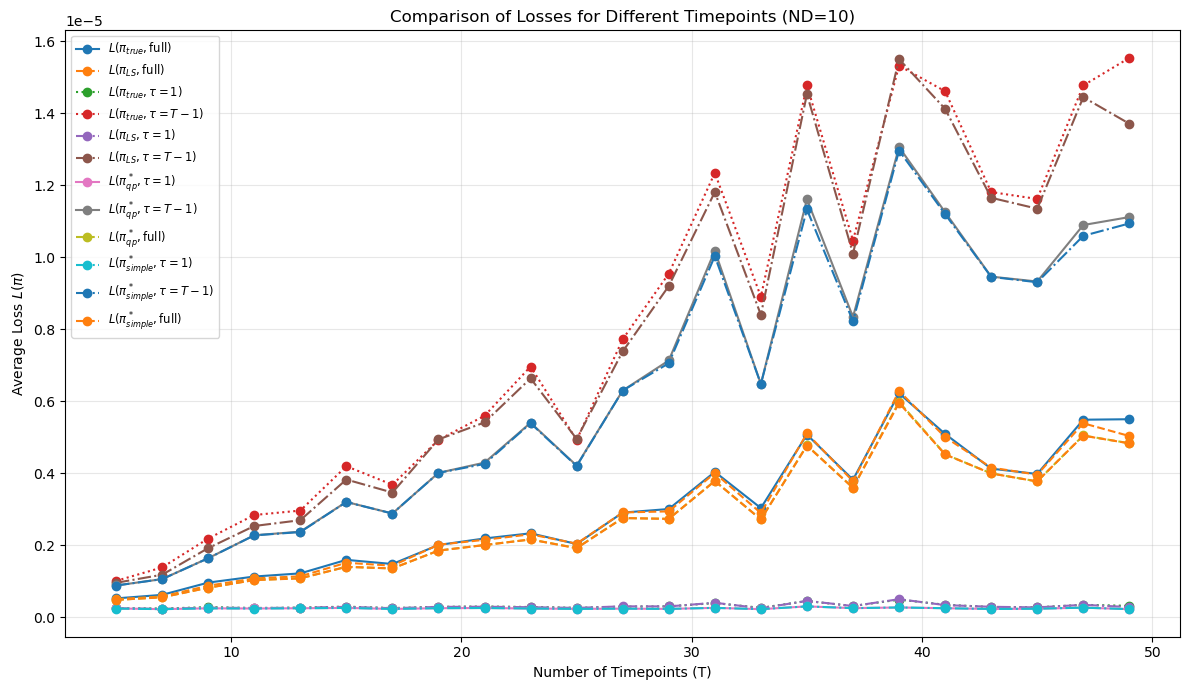

In [54]:
loss_all_times = np.array(loss_all_times)  # shape: (n_runs, 4)
Ts_unique = np.unique(Ts)

loss_avs = []
loss_stds = []

for T in Ts_unique:
    mask = Ts == T
    avg = np.mean(loss_all_times[mask], axis=0)
    std = np.std(loss_all_times[mask], axis=0)
    loss_avs.append(avg)
    loss_stds.append(std)

loss_avs = np.array(loss_avs)
loss_stds = np.array(loss_stds)

method_labels = [
    r'$L(\pi_{true}, \mathrm{full})$',
    r'$L(\pi_{LS}, \mathrm{full})$',
    r'$L(\pi_{true}, \tau=1)$',
    r'$L(\pi_{true}, \tau=T-1)$',
    r'$L(\pi_{LS}, \tau=1)$',
    r'$L(\pi_{LS}, \tau=T-1)$',
    r'$L(\pi^*_{qp}, \tau=1)$',
    r'$L(\pi^*_{qp}, \tau=T-1)$',
    r'$L(\pi^*_{qp}, \mathrm{full})$',
    r'$L(\pi^*_{simple}, \tau=1)$',
    r'$L(\pi^*_{simple}, \tau=T-1)$',
    r'$L(\pi^*_{simple}, \mathrm{full})$'
]

linestyles = [
    '-',      # true full
    '--',     # LS full
    ':',      # true tau=1
    ':',      # true tau=T-1
    '-.',     # LS tau=1
    '-.',     # LS tau=T-1
    '-',      # qp tau=1
    '-',      # qp tau=T-1
    '--',     # qp full
    '-.',     # simple tau=1
    '-.',     # simple tau=T-1
    '--'      # simple full
]

plt.figure(figsize=(12, 7))
for i in range(len(method_labels)):
    plt.plot(
        Ts_unique,
        loss_avs[:, i],
        label=method_labels[i],
        marker='o',
        linestyle=linestyles[i]
    )

plt.xlabel('Number of Timepoints (T)')
plt.ylabel('Average Loss $L(\\pi)$')
plt.title(f'Comparison of Losses for Different Timepoints (ND={ND})')
plt.legend(loc='best', fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
